#### Setup

In [ ]:
from google.colab import drive

import sys
import os
drive.mount('/content/drive')
!pip install tslearn

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 369.8/369.8 kB 6.9 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans, SpectralClustering, DBSCAN, AgglomerativeClustering
import matplotlib.pyplot as plt
import scipy
from scipy.io.wavfile import read
from scipy.signal import resample
from tslearn.clustering import KShape, TimeSeriesKMeans


#### Load Data


In [ ]:
!ls drive/MyDrive/ecog/ecog_data

EC16_cue_audio.mat	  EC22_stimulus_audio.mat   EC29_speech_audio.mat
EC16_cue_ecog.mat	  EC22_stimulus_ecog.mat    EC29_speech_ecog.mat
EC16_cue_events.csv	  EC22_stimulus_events.csv  EC29_speech_events.csv
EC16_speech_audio.mat	  EC23_cue_audio.mat	    EC29_stimulus_audio.mat
EC16_speech_ecog.mat	  EC23_cue_ecog.mat	    EC29_stimulus_ecog.mat
EC16_speech_events.csv	  EC23_cue_events.csv	    EC29_stimulus_events.csv
EC16_stimulus_audio.mat   EC23_speech_audio.mat     EC30_cue_audio.mat
EC16_stimulus_ecog.mat	  EC23_speech_ecog.mat	    EC30_cue_ecog.mat
EC16_stimulus_events.csv  EC23_speech_events.csv    EC30_cue_events.csv
EC18_cue_audio.mat	  EC23_stimulus_audio.mat   EC30_speech_audio.mat
EC18_cue_ecog.mat	  EC23_stimulus_ecog.mat    EC30_speech_ecog.mat
EC18_cue_events.csv	  EC23_stimulus_events.csv  EC30_speech_events.csv
EC18_speech_audio.mat	  EC24_cue_audio.mat	    EC30_stimulus_audio.mat
EC18_speech_ecog.mat	  EC24_cue_ecog.mat	    EC30_stimulus_ecog.mat
EC18_speech_events.csv	

In [ ]:
data_dir = '/content/drive/MyDrive/ecog'
event_nums = [16, 18, 22, 23, 24, 29, 30, 31]
events_paths = {}
ecog_paths = {}

# collect all event and ecog paths
for num in event_nums:
  events_path = 'ecog_data/EC{}_stimulus_events.csv'.format(str(num))
  ecog_path = 'ecog_data/EC{}_stimulus_ecog.mat'.format(str(num))

  events_paths[num] = events_path
  ecog_paths[num] = ecog_path


qnet_path = 'q_network_outputs(new)/'

disyllabic = ['temple', 'busy', 'delight', 'minute',
              'motive', 'native', 'double', 'balloon']

In [ ]:
word_events_per_num = {}

for num in event_nums:
  events_path = events_paths[num]
  # Load events and filter for disyllabic words
  events = pd.read_csv(
      os.path.join(data_dir, events_path),
      header=None,
      names=['event']
  )

  word_events = {}
  for word in disyllabic:
    word_events[word] = events.query(f"event=='{word}'").index

  word_events_per_num[num] = word_events

In [ ]:
ecogs_per_num = {}
word_ecogs_per_num = {}

for num in event_nums:
  ecog_path = ecog_paths[num]
  # Load ecog and filter for disyllabic words
  ecog = scipy.io.loadmat(os.path.join(data_dir, ecog_path))['ecog']
  ecogs_per_num[num] = ecog

  word_ecog = {}
  for word in disyllabic:
    try:
      word_ecog[word] = ecog[:, :, word_events[word]]
    except Exception as e:
      print(e)
      print(num, word)
      continue

  word_ecogs_per_num[num] = word_ecog


index 46 is out of bounds for axis 2 with size 27
30 temple
index 43 is out of bounds for axis 2 with size 27
30 busy
index 40 is out of bounds for axis 2 with size 27
30 delight
index 37 is out of bounds for axis 2 with size 27
30 minute
index 32 is out of bounds for axis 2 with size 27
30 motive
index 29 is out of bounds for axis 2 with size 27
30 native


In [ ]:
# Load GAN conv3 and filter for disyllabic words

# word_qnet = {}
# for word in disyllabic:
#   numbers = word_events[word]
#   arr = []
#   for i in numbers:

# Load GAN conv4 (delight)
def load_gan_data(num, word, layer):
  id1 = word_events_per_num[num][word][0]
  id2 = word_events_per_num[num][word][1]
  file1 = f'EC{str(num)}_trial{id1}_{word}_qconv{layer}.csv'
  file2 = f'EC{str(num)}_trial{id2}_{word}_qconv{layer}.csv'
  conv_a = pd.read_csv(os.path.join(data_dir, qnet_path, file1), header=None)
  conv_b = pd.read_csv(os.path.join(data_dir, qnet_path, file2), header=None)
  conv_a = conv_a.to_numpy().T  # ch x samples x batch
  conv_b = conv_b.to_numpy().T
  conv = np.stack((conv_a, conv_b), axis=2)
  return conv

def load_audio(num, word):
  audio_dir = 'sliced_audio(fixed)'
  id1 = word_events_per_num[num][word][0]
  file2 = f'EC{str(num)}_trial{id1}_{word}.wav'
  _, a = read(os.path.join(data_dir, audio_dir, file2))
  return a


conv3 = load_gan_data(18, 'busy', 2)

In [ ]:
# Load audio stimulus
a = load_audio(18, 'busy')
b = load_audio(16, 'busy')

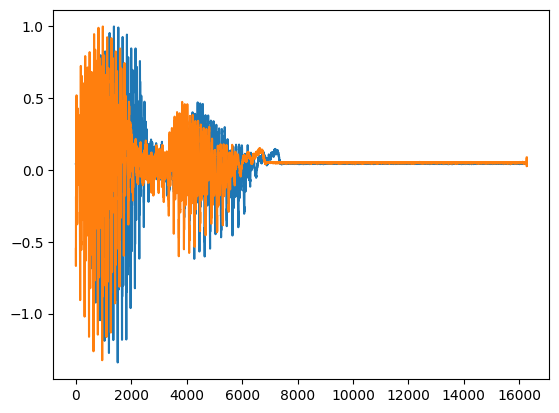

In [ ]:
plt.plot(a)
plt.plot(b)

In [ ]:
valid_nums = [16, 18, 22, 23, 24, 29, 31] #30 excluded due to dimensionality issues

In [ ]:
import os
import matplotlib.pyplot as plt
from tslearn.clustering import TimeSeriesKMeans
from tslearn.clustering import KShape
from scipy.signal import resample

# Assuming other imports and data loading code is already present

# Define the directory where you want to save the plots
plot_save_dir = '/content/drive/MyDrive/ecog_arda_copy/plots'
if not os.path.exists(plot_save_dir):
    os.makedirs(plot_save_dir)

# Define your clustering methods as functions to handle dynamic cluster number
def kmeans_clustering(data, num_clusters):
    return TimeSeriesKMeans(n_clusters=num_clusters).fit(data)

def kshape_clustering(data, num_clusters):
    return KShape(n_clusters=num_clusters).fit(data)

# Function to safely resample data if it's not empty
def safe_resample(data, num_points):
    if data.size > 0:  # Ensure data is not empty
        return resample(data, num_points)
    else:
        return np.array([])  # Return an empty array if data is empty

def process_and_plot(num, word, num_clusters, save_dir):
    # Load the data for the current word and num
    ecog = word_ecogs_per_num[num][word]
    conv = load_gan_data(num, word, 2)
    audio = load_audio(num, word)

    # Check if the ECoG or conv data is empty, and skip if so
    if ecog.size == 0 or conv.size == 0:
        print(f"Skipping {word} for num {num} due to empty data.")
        return

    # Check if the ECoG or conv data does not have at least two dimensions, and skip if so
    if ecog.ndim < 2 or conv.ndim < 2:
        print(f"Skipping {word} for num {num} due to insufficient data dimensions.")
        return

    # Apply KMeans clustering to ECoG data
    ecog_kmeans_clusters = kmeans_clustering(ecog, num_clusters)
    # Apply KShape clustering to ECoG data
    ecog_kshape_clusters = kshape_clustering(ecog, num_clusters)
    # Apply KMeans clustering to conv data
    conv_kmeans_clusters = kmeans_clustering(conv, num_clusters)
    # Apply KShape clustering to conv data
    conv_kshape_clusters = kshape_clustering(conv, num_clusters)

    # Create a figure with subplots for ECoG KMeans, ECoG KShape, conv KMeans, and conv KShape
    fig, axs = plt.subplots(4, 1, figsize=(15, 20), sharex=True)
    fig.suptitle(f'Clustering for {word} (Num: {num})')

    # Define subplots
    ax1, ax2, ax3, ax4 = axs

    # Plot KMeans clustering for ECoG data
    plot_clusters(ecog_kmeans_clusters, ecog, 'ECoG KMeans Clustering', ax1, audio)
    # Plot KShape clustering for ECoG data
    plot_clusters(ecog_kshape_clusters, ecog, 'ECoG KShape Clustering', ax2, audio)
    # Plot KMeans clustering for conv data
    plot_clusters(conv_kmeans_clusters, conv, 'Conv KMeans Clustering', ax3, audio)
    # Plot KShape clustering for conv data
    plot_clusters(conv_kshape_clusters, conv, 'Conv KShape Clustering', ax4, audio)

    # Adjust layout
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    # Save the entire figure
    plot_filename = f'EC{num}_{word}_all_clustering.png'
    plt.savefig(os.path.join(save_dir, plot_filename))
    plt.close()



def plot_clusters(clusters, data, title, ax, audio, sample_rate=16000):
    # Resample and normalize the audio for plotting if it's not empty
    if audio.size > 0:
        audio_resampled = safe_resample(audio, sample_rate)
        audio_resampled /= np.max(np.abs(audio_resampled))
        ax.plot(audio_resampled, alpha=0.3, label='Audio', linestyle='--')

    # Plot each cluster with a unique label
    for i in range(clusters.n_clusters):
        # Find the data points belonging to the current cluster
        cluster_indices = clusters.labels_ == i
        cluster_data = data[cluster_indices]

        # Skip plotting if the cluster data is empty
        if cluster_data.size == 0:
            continue

        # Calculate the mean across these points for all channels
        cluster_mean = np.mean(cluster_data, axis=0)

        # Resample and normalize the mean if it's not empty
        cluster_mean_resampled = safe_resample(cluster_mean, sample_rate)
        cluster_mean_resampled /= np.max(np.abs(cluster_mean_resampled))

        # Plot the mean of the cluster
        ax.plot(cluster_mean_resampled, label=f'Cluster {i}')

    # Set the title of the subplot and add a legend
    ax.set_title(title)
    handles, labels = ax.get_legend_handles_labels()
    by_label = dict(zip(labels, handles))  # Removes duplicates
    ax.legend(by_label.values(), by_label.keys())

In [ ]:
num_clusters = 64  # Set the desired number of clusters

plot_save_dir = '/content/drive/MyDrive/ecog_arda_copy/plots/64'  # Make sure this directory exists

# Loop through each number and word to apply clustering and save plots
for num in valid_nums:
    for word in disyllabic:
        # Skip if the data is not available for the word
        if word not in word_ecogs_per_num[num]:
            continue
        print(word)
        print(num)
        try:
          process_and_plot(num, word, num_clusters, plot_save_dir)
        except Exception as e:
          print(e)


temple
16
cannot reshape array of size 0 into shape (0,newaxis)
busy
16
cannot reshape array of size 0 into shape (0,newaxis)
delight
16
cannot reshape array of size 0 into shape (0,newaxis)
minute
16
cannot reshape array of size 0 into shape (0,newaxis)
motive
16
cannot reshape array of size 0 into shape (0,newaxis)
native
16
cannot reshape array of size 0 into shape (0,newaxis)
double
16
cannot reshape array of size 0 into shape (0,newaxis)
balloon
16
cannot reshape array of size 0 into shape (0,newaxis)
temple
18


#ENVELOPE GENERATION

In [ ]:
import os
import numpy as np
import scipy.io
import scipy.signal
from scipy.io.wavfile import read

# Function to band-pass filter the signal
def bandpass_filter(signal, low_freq, high_freq, fs, order=4):
    nyquist = 0.5 * fs
    low = low_freq / nyquist
    high = high_freq / nyquist
    b, a = scipy.signal.butter(order, [low, high], btype='band')
    return scipy.signal.lfilter(b, a, signal)

# Function to low-pass filter the signal
def lowpass_filter(signal, cutoff_freq, fs, order=4):
    nyquist = 0.5 * fs
    norm_cutoff_freq = cutoff_freq / nyquist
    b, a = scipy.signal.butter(order, norm_cutoff_freq, btype='low')
    return scipy.signal.lfilter(b, a, signal)

# Function to extract the envelope of the signal
def extract_envelope(ecog_signal, fs):
    # Band-pass filter the signal
    filtered_signal = bandpass_filter(ecog_signal, 70, 150, fs)

    # Hilbert transform to get the analytic signal
    analytic_signal = scipy.signal.hilbert(filtered_signal)

    # Envelope is the magnitude of the analytic signal
    envelope = np.abs(analytic_signal)

    # Low-pass filter the envelope to smooth it
    smoothed_envelope = lowpass_filter(envelope, 10, fs)  # 10 Hz cutoff for smoothing
    return smoothed_envelope



In [ ]:
# Define your sampling frequency for the ECoG data if known, e.g., 1000 Hz
sampling_frequency = 1000  # replace with the actual sampling frequency of your data

# Example usage for a single ECoG trial
# This is just an example; you will need to adapt it to how your data is structured
# Replace 'ecog_data' with your actual data variable
num = 18  # example participant number
word = 'busy'  # example word
trial_data = word_ecogs_per_num[num][word]  # assuming this is a 3D array: channels x time x trials

# We will process the first trial for this example
trial_ecog_signal = trial_data[:, :, 0]  # assuming you want to process the first trial

# Assuming that the ECoG data is a 2D array: channels x time
# If your data is structured differently, you'll need to adjust the code accordingly
envelopes = []
for channel_signal in trial_ecog_signal:
    envelope = extract_envelope(channel_signal, sampling_frequency)
    envelopes.append(envelope)

# Now 'envelopes' contains the speech envelopes for all channels for the first trial
# You can plot them, or continue with further analysis as needed


In [ ]:
# len(trial_ecog_signal)
len(envelopes)

256

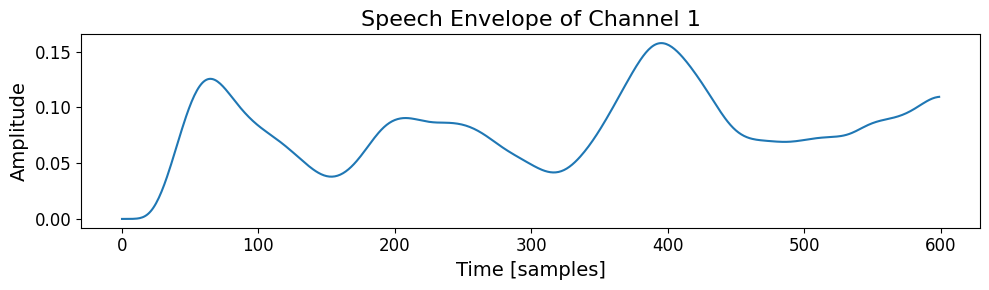

In [ ]:
import matplotlib.pyplot as plt

# Let's say you want to plot the envelope for the first channel
envelope_to_plot = envelopes[0]  # Replace 0 with the index of the channel you want to plot

plt.figure(figsize=(10, 3))  # Set the width and height of the plot
plt.plot(envelope_to_plot)
plt.title('Speech Envelope of Channel 1', fontsize=16)
plt.xlabel('Time [samples]', fontsize=14)
plt.ylabel('Amplitude', fontsize=14)
plt.tick_params(axis='both', labelsize=12)  # Enlarge labels for both axes
plt.tight_layout()  # Adjust subplot params for the plot to fit into the figure area
plt.show()


In [ ]:
audio_file = 'your_audio.wav'  # Replace with the path to your audio file
audio_fs, audio_data = read(audio_file)

# Synchronize time scales between ECoG and audio data
# You may need to adjust the timing to match your data
ecog_time = np.arange(len(envelope_to_plot)) / sampling_frequency
audio_time = np.arange(len(audio_data)) / audio_fs

# Create subplots for envelope and audio waveform
fig, axs = plt.subplots(2, 1, figsize=(10, 6), sharex=True)

# Plot the envelope
axs[0].plot(ecog_time, envelope_to_plot)
axs[0].set_title('Speech Envelope of Channel 1', fontsize=16)
axs[0].set_ylabel('Amplitude', fontsize=14)
axs[0].tick_params(axis='both', labelsize=12)

# Plot the audio waveform
axs[1].plot(audio_time, audio_data, color='red')
axs[1].set_title('Audio Waveform', fontsize=16)
axs[1].set_xlabel('Time [seconds]', fontsize=14)
axs[1].set_ylabel('Amplitude', fontsize=14)
axs[1].tick_params(axis='both', labelsize=12)

plt.tight_layout()  # Adjust subplot params for the plot to fit into the figure area
plt.show()


FileNotFoundError: ignored

ENVELOPE @

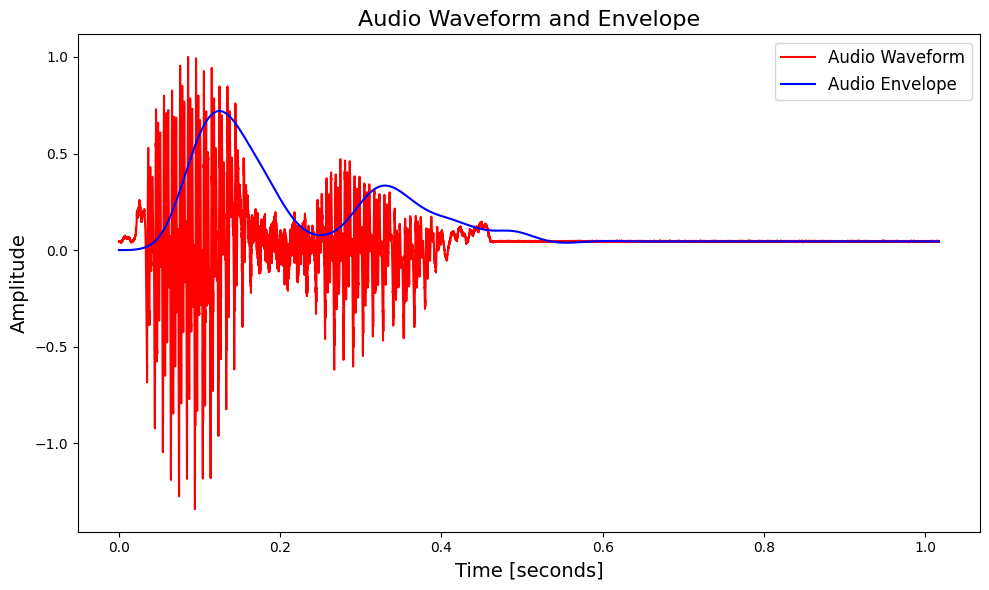

In [ ]:
import os
import numpy as np
import scipy.io
import scipy.signal
from scipy.io.wavfile import read
import matplotlib.pyplot as plt

# Function to band-pass filter the signal
def bandpass_filter(signal, low_freq, high_freq, fs, order=4):
    nyquist = 0.5 * fs
    low = low_freq / nyquist
    high = high_freq / nyquist
    b, a = scipy.signal.butter(order, [low, high], btype='band')
    return scipy.signal.lfilter(b, a, signal)

# Function to low-pass filter the signal
def lowpass_filter(signal, cutoff_freq, fs, order=4):
    nyquist = 0.5 * fs
    norm_cutoff_freq = cutoff_freq / nyquist
    b, a = scipy.signal.butter(order, norm_cutoff_freq, btype='low')
    return scipy.signal.lfilter(b, a, signal)

# Function to extract the envelope of the signal
def extract_envelope(signal, fs):
    # Hilbert transform to get the analytic signal
    analytic_signal = scipy.signal.hilbert(signal)

    # Envelope is the magnitude of the analytic signal
    envelope = np.abs(analytic_signal)

    # Low-pass filter the envelope to smooth it
    smoothed_envelope = lowpass_filter(envelope, 10, fs)  # 10 Hz cutoff for smoothing
    return smoothed_envelope

# Custom function to load audio
def load_audio(num, word, audio_dir):
    id1 = word_events_per_num[num][word][0]
    file1 = f'EC{str(num)}_trial{id1}_{word}.wav'
    _, audio_data = read(os.path.join(data_dir, audio_dir, file1))
    return audio_data

# Define your sampling frequency for the audio data (16 kHz)
audio_fs = 16000

# Load the audio file using your custom function
audio_data = load_audio(18, 'busy', 'sliced_audio(fixed)')

# Synchronize time scales for audio data
audio_time = np.arange(len(audio_data)) / audio_fs

# Extract the envelope of the audio
audio_envelope = extract_envelope(audio_data, audio_fs)

# Create a single subplot to plot both audio waveform and envelope
plt.figure(figsize=(10, 6))

# Plot the audio waveform in red
plt.plot(audio_time, audio_data, color='red', label='Audio Waveform')

# Plot the audio envelope in blue
plt.plot(audio_time, audio_envelope, color='blue', label='Audio Envelope')

plt.title('Audio Waveform and Envelope', fontsize=16)
plt.xlabel('Time [seconds]', fontsize=14)
plt.ylabel('Amplitude', fontsize=14)
plt.legend(fontsize=12)

plt.tight_layout()  # Adjust subplot params for the plot to fit into the figure area
plt.show()


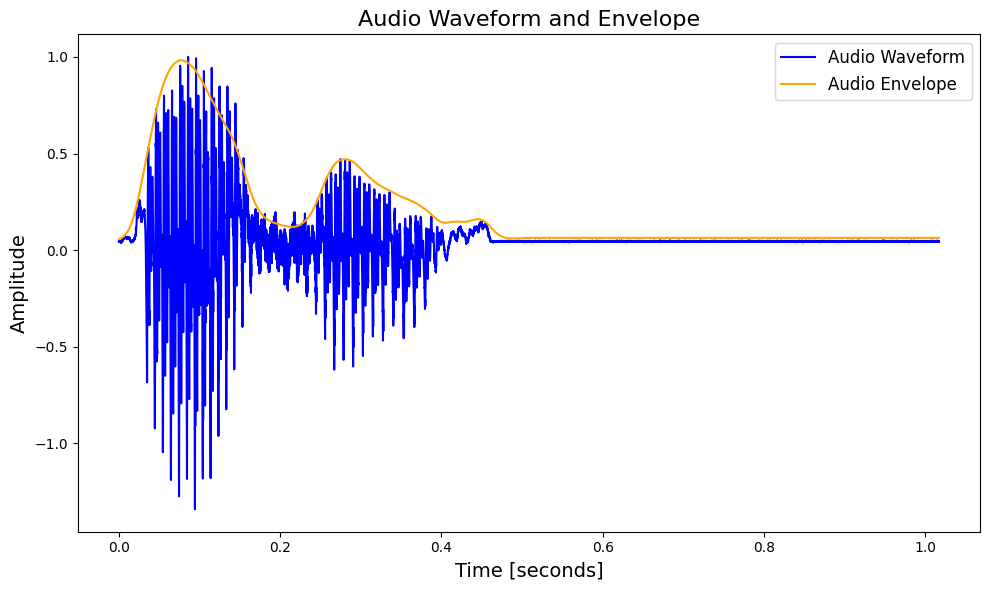

In [ ]:
import numpy as np
import scipy.signal
import matplotlib.pyplot as plt

# Function to low-pass filter the signal
def lowpass_filter(signal, cutoff_freq, fs, order=2):
    nyquist = 0.5 * fs
    norm_cutoff_freq = cutoff_freq / nyquist
    b, a = scipy.signal.butter(order, norm_cutoff_freq, btype='low')
    return scipy.signal.filtfilt(b, a, signal)

# Function to extract the envelope of the signal
def extract_envelope(signal, fs, cutoff_freq=20, scale_factor=1.4):  # Added scale_factor
    analytic_signal = scipy.signal.hilbert(signal)
    envelope = np.abs(analytic_signal)
    smoothed_envelope = lowpass_filter(envelope, cutoff_freq, fs)
    scaled_envelope = smoothed_envelope * scale_factor  # Scale the envelope
    return scaled_envelope

def load_audio(num, word, audio_dir):
    id1 = word_events_per_num[num][word][0]
    file1 = f'EC{str(num)}_trial{id1}_{word}.wav'
    _, audio_data = read(os.path.join(data_dir, audio_dir, file1))
    return audio_data

# Define your sampling frequency for the audio data (16 kHz)
audio_fs = 16000

# Load the audio file using your custom function
audio_data = load_audio(18, 'busy', 'sliced_audio(fixed)')

# Synchronize time scales for audio data
audio_time = np.arange(len(audio_data)) / audio_fs

# Extract the envelope of the audio
audio_envelope = extract_envelope(audio_data, audio_fs)

# Create a single subplot to plot both audio waveform and envelope
plt.figure(figsize=(10, 6))

# Plot the audio waveform
plt.plot(audio_time, audio_data, color='blue', label='Audio Waveform')

# Plot the audio envelope
plt.plot(audio_time, audio_envelope, color='orange', label='Audio Envelope')

plt.title('Audio Waveform and Envelope', fontsize=16)
plt.xlabel('Time [seconds]', fontsize=14)
plt.ylabel('Amplitude', fontsize=14)
plt.legend(fontsize=12)
plt.tight_layout()
plt.show()


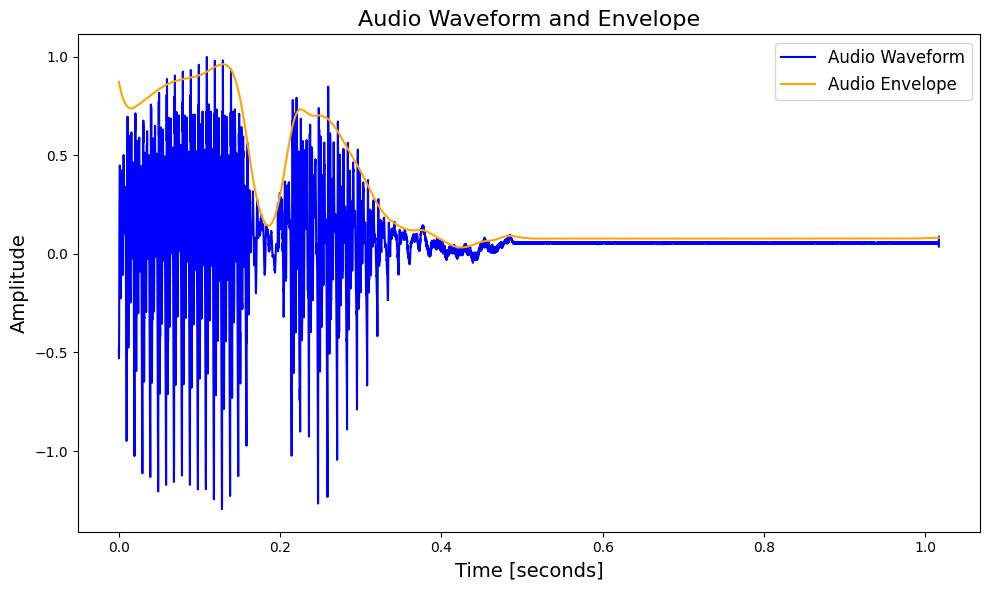

In [ ]:
# Load the audio file using your custom function
audio_data = load_audio(18, 'native', 'sliced_audio(fixed)')

# Synchronize time scales for audio data
audio_time = np.arange(len(audio_data)) / audio_fs

# Extract the envelope of the audio
audio_envelope = extract_envelope(audio_data, audio_fs)

# Create a single subplot to plot both audio waveform and envelope
plt.figure(figsize=(10, 6))

# Plot the audio waveform
plt.plot(audio_time, audio_data, color='blue', label='Audio Waveform')

# Plot the audio envelope
plt.plot(audio_time, audio_envelope, color='orange', label='Audio Envelope')

plt.title('Audio Waveform and Envelope', fontsize=16)
plt.xlabel('Time [seconds]', fontsize=14)
plt.ylabel('Amplitude', fontsize=14)
plt.legend(fontsize=12)
plt.tight_layout()
plt.show()


In [ ]:
disyllabic = ['temple', 'busy', 'delight', 'minute',
              'motive', 'native', 'double', 'balloon']

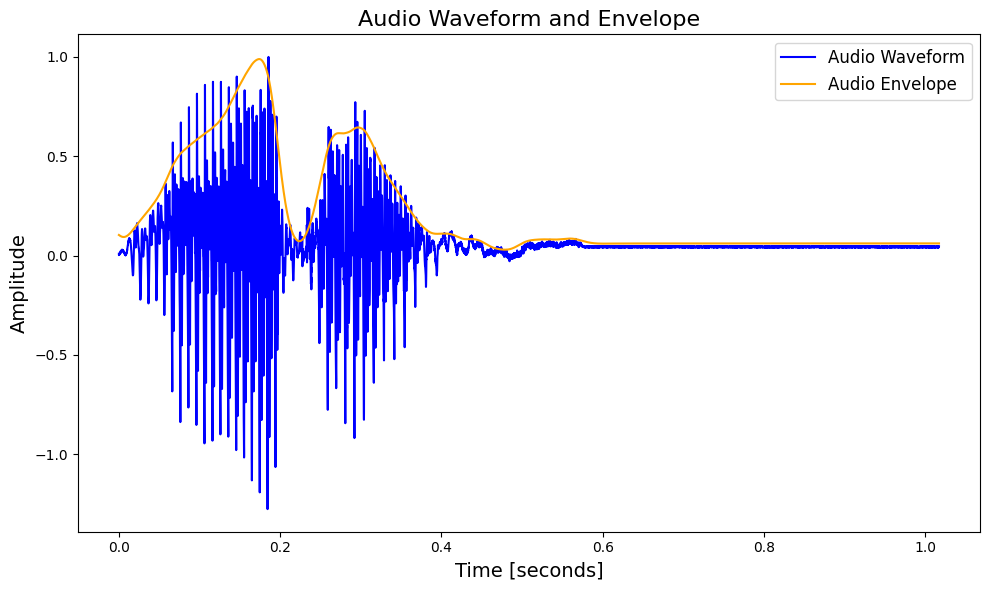

In [ ]:
# Load the audio file using your custom function
audio_data = load_audio(16, 'motive', 'sliced_audio(fixed)')

# Synchronize time scales for audio data
audio_time = np.arange(len(audio_data)) / audio_fs

# Extract the envelope of the audio
audio_envelope = extract_envelope(audio_data, audio_fs)

# Create a single subplot to plot both audio waveform and envelope
plt.figure(figsize=(10, 6))

# Plot the audio waveform
plt.plot(audio_time, audio_data, color='blue', label='Audio Waveform')

# Plot the audio envelope
plt.plot(audio_time, audio_envelope, color='orange', label='Audio Envelope')

plt.title('Audio Waveform and Envelope', fontsize=16)
plt.xlabel('Time [seconds]', fontsize=14)
plt.ylabel('Amplitude', fontsize=14)
plt.legend(fontsize=12)
plt.tight_layout()
plt.show()


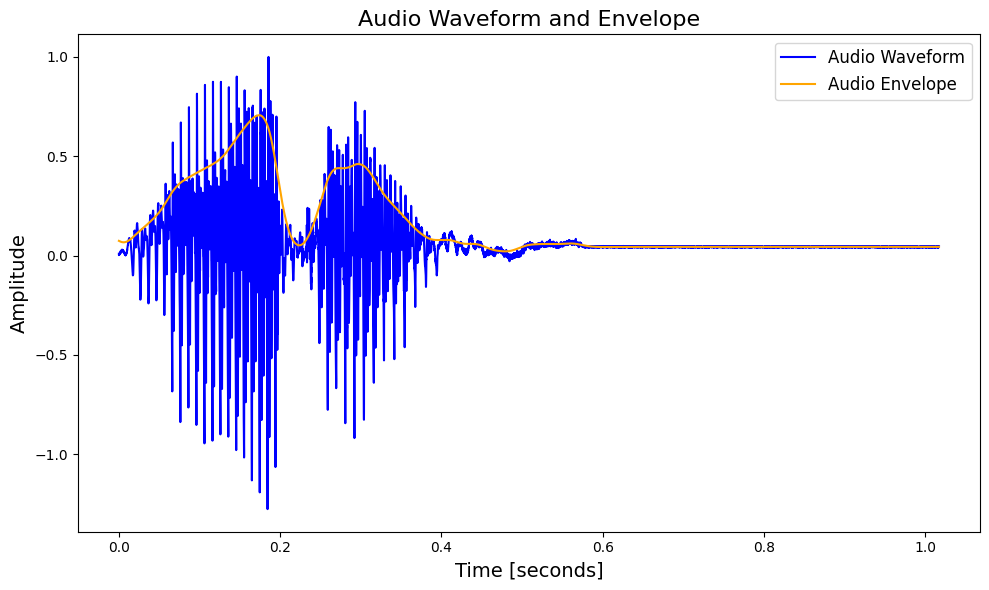

In [ ]:
# Load the audio file using your custom function
# audio_data = load_audio(22, 'balloon', 'sliced_audio(fixed)')
audio_data = load_audio(16, 'motive', 'sliced_audio(fixed)')


# Synchronize time scales for audio data
audio_time = np.arange(len(audio_data)) / audio_fs

# Extract the envelope of the audio
audio_envelope = extract_envelope(audio_data, audio_fs)

# Create a single subplot to plot both audio waveform and envelope
plt.figure(figsize=(10, 6))

# Plot the audio waveform
plt.plot(audio_time, audio_data, color='blue', label='Audio Waveform')

# Plot the audio envelope
plt.plot(audio_time, audio_envelope, color='orange', label='Audio Envelope')

plt.title('Audio Waveform and Envelope', fontsize=16)
plt.xlabel('Time [seconds]', fontsize=14)
plt.ylabel('Amplitude', fontsize=14)
plt.legend(fontsize=12)
plt.tight_layout()
plt.show()


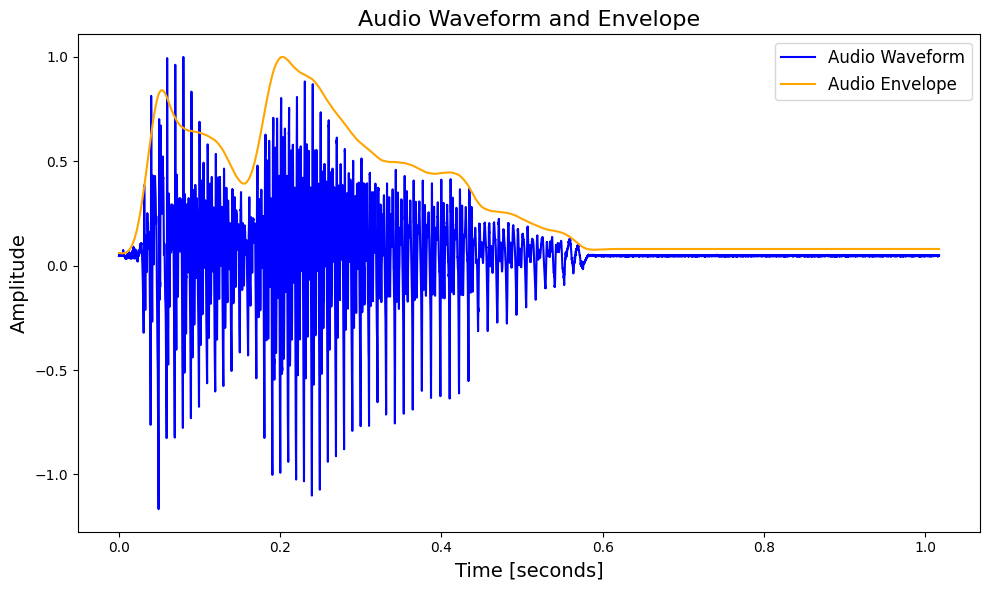

In [ ]:
import numpy as np
import scipy.signal
import matplotlib.pyplot as plt

# Function to low-pass filter the signal
def lowpass_filter(signal, cutoff_freq, fs, order=2):
    nyquist = 0.5 * fs
    norm_cutoff_freq = cutoff_freq / nyquist
    b, a = scipy.signal.butter(order, norm_cutoff_freq, btype='low')
    return scipy.signal.filtfilt(b, a, signal)

# Function to extract the envelope of the signal
def extract_envelope(signal, fs, cutoff_freq=20):
    analytic_signal = scipy.signal.hilbert(signal)
    envelope = np.abs(analytic_signal)
    smoothed_envelope = lowpass_filter(envelope, cutoff_freq, fs)
    return smoothed_envelope

# Function to find peaks and scale the envelope
def scale_envelope_to_peaks(signal, envelope, scale_factor=1.0):
    peaks, _ = scipy.signal.find_peaks(signal)
    peak_values = signal[peaks]
    max_peak_value = np.max(peak_values)

    envelope_peaks, _ = scipy.signal.find_peaks(envelope)
    max_envelope_peak = np.max(envelope[envelope_peaks])

    # Calculate scale factor if not provided
    if scale_factor is None:
        scale_factor = max_peak_value / max_envelope_peak

    scaled_envelope = envelope * scale_factor
    return scaled_envelope, peaks

audio_data = load_audio(22, 'balloon', 'sliced_audio(fixed)')

# Synchronize time scales for audio data
audio_time = np.arange(len(audio_data)) / audio_fs

# Extract the envelope of the audio
audio_envelope = extract_envelope(audio_data, audio_fs)

# Scale the envelope to match the peaks of the audio waveform
scaled_envelope, peaks = scale_envelope_to_peaks(audio_data, audio_envelope, scale_factor=None)

# Create a subplot to plot both audio waveform and envelope
plt.figure(figsize=(10, 6))

# Plot the audio waveform
plt.plot(audio_time, audio_data, color='blue', label='Audio Waveform')

# Plot the scaled audio envelope
plt.plot(audio_time, scaled_envelope, color='orange', label='Audio Envelope')

# Mark the peaks on the waveform
# plt.plot(audio_time[peaks], audio_data[peaks], "x", color='red', label='Peaks')

plt.title('Audio Waveform and Envelope', fontsize=16)
plt.xlabel('Time [seconds]', fontsize=14)
plt.ylabel('Amplitude', fontsize=14)
plt.legend(fontsize=12)
plt.tight_layout()
plt.show()


# PAST

#### Examining single word

In [ ]:
meaned = 0
n = 0
for word in disyllabic:
  meaned += np.mean(word_ecog[word], axis=-1)

meaned /= len(disyllabic)

In [ ]:
conv = conv3
ecog = word_ecog[word]

ecog_curr = ecog[:, 300:, 0]
conv_curr = conv[:, :, 0]

ecog_meaned = meaned[:, 300:]

# ecog_sums = ecog1.sum(axis=1)
# ecog1 = ecog1 / ecog_sums[:, np.newaxis]

# conv_sums = conv3a.sum(axis=1)
# conv3a = conv3a / conv_sums[:, np.newaxis]

In [ ]:
num_clusters = 2

kmeans_cluster = lambda x: TimeSeriesKMeans(num_clusters).fit(x)
kshape_cluster = lambda x: KShape(num_clusters).fit(x)


[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 0 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 1 1
 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 1 1 1 1 1 1
 1 1 1 1 1 1 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1
 1 1 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 0 1 0 0
 0 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1
 0 1 1 1 1 1 1 1 1 0 1 1 0 1 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1]


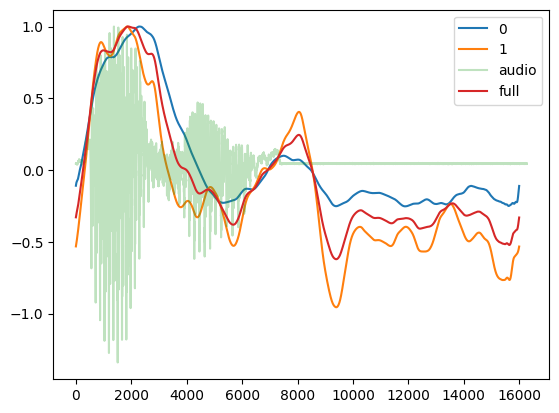

In [ ]:
# ecog_curr /= np.max(np.abs(ecog_curr))
ecog_clusters = cluster(ecog_meaned)
for i in range(num_clusters):
  data = np.mean(ecog_curr[ecog_clusters.labels_==i], axis=0)
  data = resample(data, 16000)
  data /= np.max(np.abs(data))
  plt.plot(data, label=i)
plt.plot(a, alpha=0.3, label='audio')
plt.plot(resample(np.mean(ecog_curr, axis=0)/np.max(np.abs(np.mean(ecog_curr, axis=0))), 16000), label='full')
plt.legend()

print(ecog_clusters.labels_)

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 1 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 0 0 0 0 0 0
 0 0 0 0 0 0 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0
 0 0 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 0 0 0 0 0 0 0 0 0 0 0 1 0 1 1
 1 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 1 0 1 0
 1 0 0 0 0 0 0 0 0 1 0 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 1 1 1 0 1 1 1]


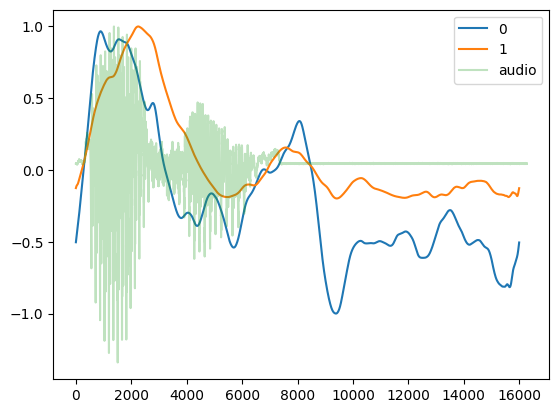

In [ ]:
# full_ecog /= np.max(np.abs(full_ecog))
full_clusters = cluster(full_ecog)
for i in range(num_clusters):
  data = np.mean(ecog_curr[full_clusters.labels_==i], axis=0)
  data = resample(data, 16000)
  data /= np.max(np.abs(data))
  plt.plot(data, label=i)
plt.plot(a, alpha=0.3, label='audio')
plt.legend()
print(full_clusters.labels_)

[1 1 0 1 1 0 1 0 1 1 1 0 1 1 1 1 1 0 1 1 1 1 1 0 1 1 1 0 1 1 1 1 0 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 1 1 1 1 1 0 1 1 0 0 0 1 0 0 1 0 0 0 1 1 0
 0 1 0 1 1 0 1 1 0 1 0 1 1 1 0 0 0 1 0 0 1 1 0 1 0 1 1 1 1 0 0 1 1 1 1 1 0
 0 1 1 1 0 1 1 1 1 1 1 1 1 0 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 0 0 1
 0 1 1 1 1 0 1 0 0 1 1 1 1 0 1 1 1 1 0 1 0 1 1 1 1 1 1 0 1 1 1 1 0 1 1 0 1
 1 1 1 1 0 0 1 0 1 1 1 1 1 1 1 0 0 0 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 0 0 0
 1 0 1 1 1 0 1 1 1 0 1 1 1 0 0 1 1 1 1 1 1 1 1 1 0 1 1 0 1 1 1 1 1 1]


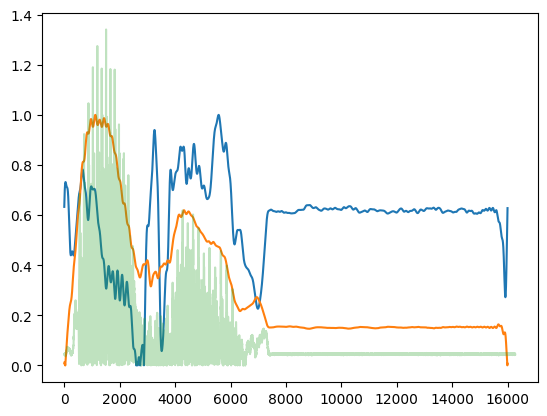

In [ ]:
conv_clusters = cluster(conv_curr)
for i in range(num_clusters):
  data = np.mean(conv_curr[conv_clusters.labels_==i], axis=0)
  data = resample(data, 16000)
  data = data/np.max(np.abs(data))
  plt.plot(np.abs(data))

# total = np.mean(conv_curr, axis=0)
# total = resample(total, 16000)
# total = total / np.max(np.abs(total))
# plt.plot(total)

print(conv_clusters.labels_)
plt.plot(np.abs(a), alpha=0.3)

# Narrowing in on Conv

[0 2 7 2 6 7 5 3 6 5 6 3 6 2 2 2 6 7 5 2 6 2 6 1 0 4 2 0 2 6 2 2 0 6 0 2 2
 6 5 6 2 6 6 6 4 2 5 2 2 6 3 3 7 2 6 2 5 6 1 6 0 3 3 1 6 0 0 6 7 3 3 2 2 3
 7 6 3 4 6 3 2 6 3 2 3 5 6 6 3 3 0 2 1 1 2 2 7 6 7 2 2 6 6 3 3 6 6 6 6 2 3
 3 0 2 0 3 6 6 2 2 2 2 0 6 4 6 2 3 2 0 2 0 6 2 6 5 5 6 2 6 3 2 2 6 6 3 4 5
 3 2 2 0 6 3 2 4 3 5 6 0 5 3 6 5 2 2 7 2 3 6 2 5 2 2 2 0 6 6 2 4 7 2 6 0 6
 4 6 2 2 4 1 4 7 2 2 6 2 2 6 5 3 3 1 0 2 2 0 4 6 7 6 2 5 2 6 6 6 2 2 3 3 3
 6 4 6 6 0 1 6 4 4 1 4 4 6 0 4 6 6 2 0 6 2 0 2 2 1 6 6 3 6 0 6 5 4 2]


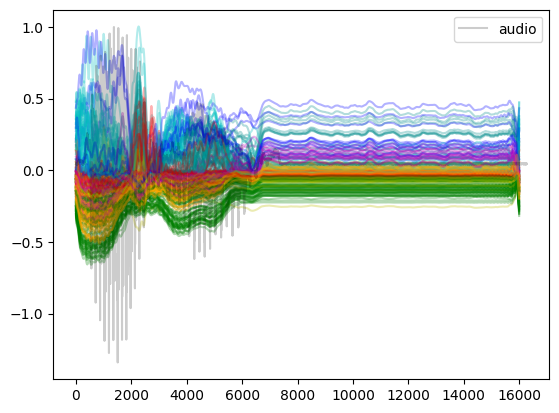

In [ ]:
conv_curr = load_gan_data('busy', 2)[:, :, 1]

num_clusters = 8
cluster = lambda x: TimeSeriesKMeans(num_clusters).fit(x)
denoms = np.max(np.abs(conv_curr), axis=1)
conv_normed = conv_curr / denoms[:, np.newaxis]
full_clusters = cluster(conv_normed)
colors = ['r', 'b', 'g', 'c', 'm', 'y', 'orange', 'darkcyan', 'chartreuse', 'sienna']
for i, ch in enumerate(conv_curr):
  ch = resample(ch, 16000)
  ch = ch / np.max(np.abs(conv_curr))
  # plt.plot(ch, color='k', alpha=0.3)
  plt.plot(ch, color=colors[full_clusters.labels_[i]], alpha=0.3)
plt.plot(a, alpha=0.2, label='audio', color='k')
plt.legend()
print(full_clusters.labels_)

[0 2 7 2 6 7 5 3 6 5 6 3 6 2 2 2 6 7 5 2 6 2 6 1 0 4 2 0 2 6 2 2 0 6 0 2 2
 6 5 6 2 6 6 6 4 2 5 2 2 6 3 3 7 2 6 2 5 6 1 6 0 3 3 1 6 0 0 6 7 3 3 2 2 3
 7 6 3 4 6 3 2 6 3 2 3 5 6 6 3 3 0 2 1 1 2 2 7 6 7 2 2 6 6 3 3 6 6 6 6 2 3
 3 0 2 0 3 6 6 2 2 2 2 0 6 4 6 2 3 2 0 2 0 6 2 6 5 5 6 2 6 3 2 2 6 6 3 4 5
 3 2 2 0 6 3 2 4 3 5 6 0 5 3 6 5 2 2 7 2 3 6 2 5 2 2 2 0 6 6 2 4 7 2 6 0 6
 4 6 2 2 4 1 4 7 2 2 6 2 2 6 5 3 3 1 0 2 2 0 4 6 7 6 2 5 2 6 6 6 2 2 3 3 3
 6 4 6 6 0 1 6 4 4 1 4 4 6 0 4 6 6 2 0 6 2 0 2 2 1 6 6 3 6 0 6 5 4 2]


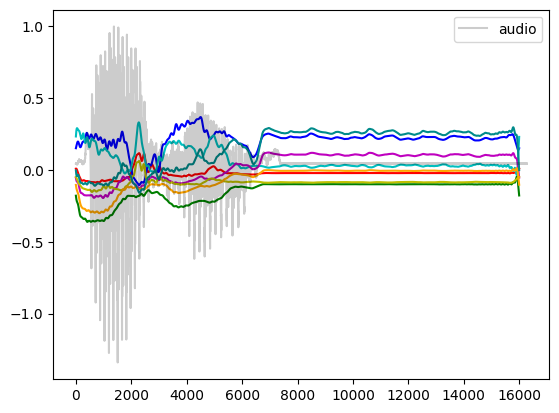

In [ ]:
for i in range(num_clusters):
  conv_currx = conv_curr / np.max(np.abs(conv_curr))
  ch = np.mean(conv_currx[full_clusters.labels_==i], axis=0)
  ch = resample(ch, 16000)
  # plt.plot(ch, color='k', alpha=0.3)
  plt.plot(ch, color=colors[i])
plt.plot(a, alpha=0.2, label='audio', color='k')
plt.legend()
print(full_clusters.labels_)

## Collecting conv over all words

In [ ]:
words = []
for word in disyllabic:
  words.append(load_gan_data(word, 2))
all_words = np.array(words)
all_words = np.mean(all_words, axis=0)
all_words = all_words[:, :, 0]
# all_words = np.mean(all_words, axis=-1)

In [ ]:
num_clusters = 8
cluster = lambda x: TimeSeriesKMeans(num_clusters).fit(x)
denoms = np.max(np.abs(all_words), axis=1)
conv_normed = all_words / denoms[:, np.newaxis]
full_clusters = cluster(conv_normed)


[1 3 0 3 1 0 3 2 1 3 1 6 1 3 3 3 3 0 3 3 1 3 1 4 1 5 3 7 3 1 3 3 2 1 3 3 3
 1 3 1 3 1 1 1 5 3 3 3 3 1 6 2 0 3 1 3 7 1 4 1 3 4 6 4 1 3 7 1 0 6 4 3 3 2
 0 1 2 5 1 2 3 1 6 3 4 3 1 1 6 6 2 3 4 0 3 3 0 1 0 3 3 1 1 2 4 1 1 1 1 3 2
 6 3 3 7 6 1 1 3 3 3 3 3 1 0 1 3 4 3 7 3 7 1 3 1 7 7 1 3 1 6 3 3 1 1 4 5 3
 6 3 3 2 1 2 3 5 6 3 1 3 3 4 1 3 3 3 0 1 4 1 3 3 3 3 3 1 1 1 3 5 0 3 1 6 1
 5 1 3 3 5 0 5 0 3 3 1 3 3 1 7 6 2 4 3 3 3 1 5 1 5 1 3 7 3 1 1 1 3 3 6 6 4
 1 0 1 1 1 0 1 5 5 4 5 5 1 2 0 1 1 3 3 1 3 3 3 3 4 1 1 2 1 3 1 3 5 3]


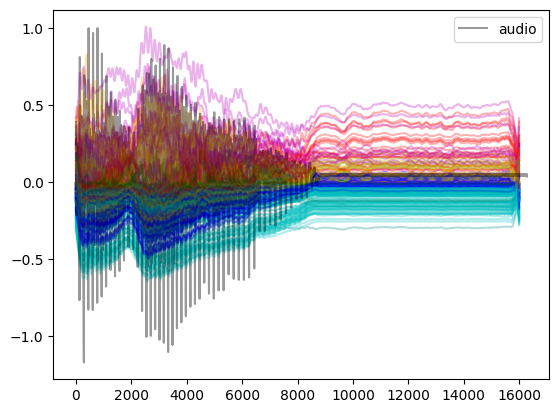

In [ ]:
word = 'balloon'
conv_curr = load_gan_data(word, 2)[:, :, 0]
a = load_audio(word)
colors = ['r', 'b', 'g', 'c', 'm', 'y', 'orange', 'darkcyan', 'chartreuse', 'sienna']
for i, ch in enumerate(conv_curr):
  ch = resample(ch, 16000)
  ch = ch / np.max(np.abs(conv_curr))
  # plt.plot(ch, color='k', alpha=0.3)
  plt.plot(ch, color=colors[full_clusters.labels_[i]], alpha=0.3)
plt.plot(a, alpha=0.4, label='audio', color='k')
plt.legend()
print(full_clusters.labels_)

[1 3 0 3 1 0 3 2 1 3 1 6 1 3 3 3 3 0 3 3 1 3 1 4 1 5 3 7 3 1 3 3 2 1 3 3 3
 1 3 1 3 1 1 1 5 3 3 3 3 1 6 2 0 3 1 3 7 1 4 1 3 4 6 4 1 3 7 1 0 6 4 3 3 2
 0 1 2 5 1 2 3 1 6 3 4 3 1 1 6 6 2 3 4 0 3 3 0 1 0 3 3 1 1 2 4 1 1 1 1 3 2
 6 3 3 7 6 1 1 3 3 3 3 3 1 0 1 3 4 3 7 3 7 1 3 1 7 7 1 3 1 6 3 3 1 1 4 5 3
 6 3 3 2 1 2 3 5 6 3 1 3 3 4 1 3 3 3 0 1 4 1 3 3 3 3 3 1 1 1 3 5 0 3 1 6 1
 5 1 3 3 5 0 5 0 3 3 1 3 3 1 7 6 2 4 3 3 3 1 5 1 5 1 3 7 3 1 1 1 3 3 6 6 4
 1 0 1 1 1 0 1 5 5 4 5 5 1 2 0 1 1 3 3 1 3 3 3 3 4 1 1 2 1 3 1 3 5 3]


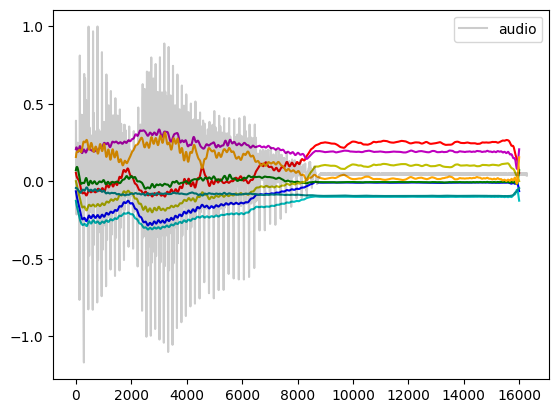

In [ ]:
for i in range(num_clusters):
  conv_currx = conv_curr / np.max(np.abs(conv_curr))
  ch = np.mean(conv_currx[full_clusters.labels_==i], axis=0)
  ch = resample(ch, 16000)
  # plt.plot(ch, color='k', alpha=0.3)
  plt.plot(ch, color=colors[i])
plt.plot(a, alpha=0.2, label='audio', color='k')
plt.legend()
print(full_clusters.labels_)